In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import Sim

In [5]:
%%time

import os
os.environ['CATSIM_DIR'] = '/Users/Matt/CATSIM_DIR'

des_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.263,
    psf_type='ps',
    n_coadd=10 * 3,
    n_coadd_psf=1,
    psf_kws={'trunc': 1, 'median_seeing': 0.8},
    gal_kws={'survey_name': 'DES'},
    mask_and_interp=True)

lsst_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.2,
    # we have to adjust these so we get a patch that is the same size in LSST
    # in order to compare the simulations
    dim=300,
    buff=25,
    psf_type='ps',
    n_coadd=300 * 3,
    n_coadd_psf=1,
    psf_kws={'trunc': 1, 'median_seeing': 0.6},
    gal_kws={'survey_name': 'LSST'},
    mask_and_interp=True)

CPU times: user 98 ms, sys: 123 ms, total: 221 ms
Wall time: 221 ms


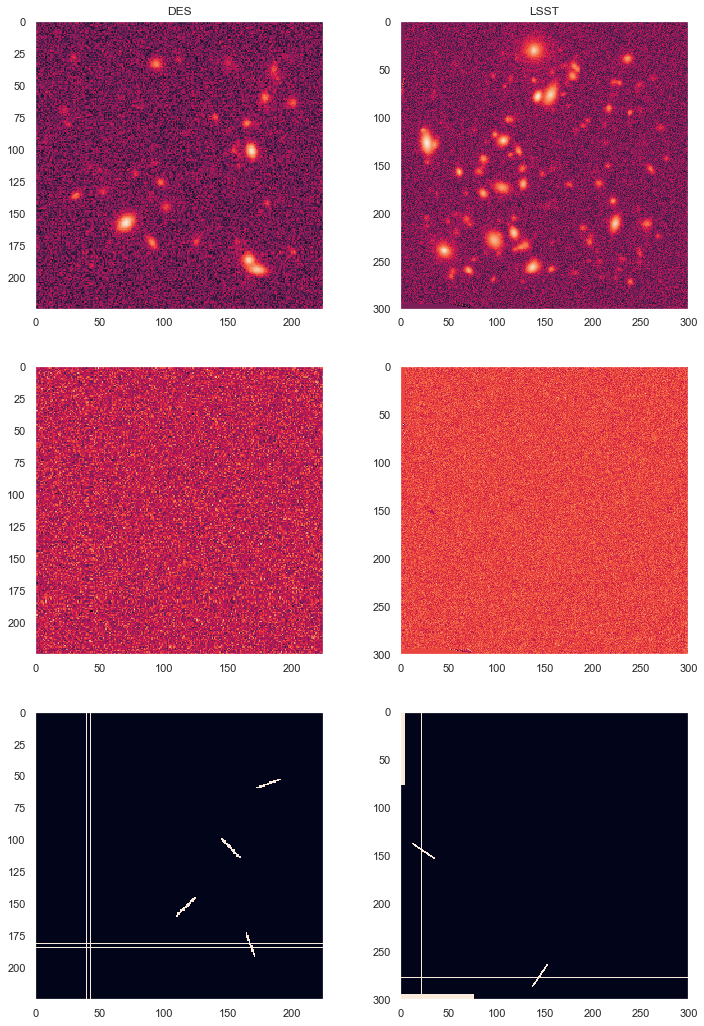

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

des_mbobs = des_sim.get_mbobs()
lsst_mbobs = lsst_sim.get_mbobs()

ax = axs[0, 0]
ax.imshow(np.arcsinh(des_mbobs[0][0].image/des_sim.noise))
ax.grid(False)
ax.set_title('DES')

ax = axs[0, 1]
ax.imshow(np.arcsinh(lsst_mbobs[0][0].image/lsst_sim.noise))
ax.grid(False)
ax.set_title('LSST')

ax = axs[1, 0]
ax.imshow(des_mbobs[0][0].noise)
ax.grid(False)

ax = axs[1, 1]
ax.imshow(lsst_mbobs[0][0].noise)
ax.grid(False)

ax = axs[2, 0]
ax.imshow(des_mbobs[0][0].bmask)
ax.grid(False)

ax = axs[2, 1]
ax.imshow(lsst_mbobs[0][0].bmask)
ax.grid(False)

In [ ]:
psf_obs1 = sim.get_psf_obs(x=0, y=30)
psf_obs2 = sim.get_psf_obs(x=10, y=120)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.heatmap(psf_obs1.image, square=True, ax=axs[0])

sns.heatmap((psf_obs2.image - psf_obs1.image) / np.max(psf_obs1.image), square=True, ax=axs[1])

In [ ]:
from mdetsims.masking import generate_bad_columns, generate_cosmic_rays

fig, axs = plt.subplots(nrows=3, ncols=3, sharex='all', sharey='all', figsize=(10, 10))

for ax in axs.ravel():
    msk = np.zeros((225, 225)).astype(bool)
    msk |= generate_cosmic_rays(msk.shape)
    msk |= generate_bad_columns(msk.shape)
    ax.imshow(1-msk, vmin=0, vmax=1)
    ax.grid(False)

In [ ]:
des_sim.nobj

In [ ]:
lsst_sim.nobj